<a href="https://colab.research.google.com/github/DaliaAlzubi/Kidney_Tumor/blob/main/Tumor_type_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## steps : 

1. read Data (excel file ) from google drive , images 
2. unzip images file
3. read images 
4. preparation
4. split data to  taring 80 % , testing 20%
5. normalization images
6. building model
7. compile model 
8. fit model 
9. test model
10. Plot the results

In [ ]:
# -*- coding: utf-8 -*-
import seaborn as sns; sns.set(color_codes=True)  # visualization tool
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os

import statistics
import collections
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from datetime import datetime
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import (
                    MultinomialNB, 
                    GaussianNB, 
                    BernoulliNB
                    )
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import (
                    SVC, 
                    NuSVC, 
                    LinearSVC
                    )
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing  import StandardScaler
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

from IPython.display import display 
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

import keras
from keras.models import Sequential , Model
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,MaxPooling2D,Input,Conv2DTranspose,Concatenate,BatchNormalization,UpSampling2D,AveragePooling2D,GlobalAveragePooling2D,Activation
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import Adam , SGD
from keras.layers.merge import concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report,confusion_matrix
from PIL import Image
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import itertools

from IPython.display import display, HTML


In [ ]:
#ً!unzip sample_data/images_data.zip -d sample_data/

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
patient_info = drive.CreateFile({'id':"1cWmJm6-MPhhDMxhkBnQzMnANjVofmdG_"})
patient_info.GetContentFile("patient_info.csv")
patient_info = pd.read_csv("patient_info.csv")

In [ ]:
patient_info["Tumor_type_label"]= patient_info["Tumor_Type"]
cleanup_nums = {
    "Tumor_type_label":{'Null':None  , "Benign":0 , 'Malignant':1 }
}
patient_info = patient_info.replace(cleanup_nums)

del cleanup_nums

In [ ]:
patient_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient_ID                       120 non-null    object 
 1   Patient_Num                      120 non-null    int64  
 2   Age                              120 non-null    int64  
 3   Gender                           120 non-null    object 
 4   Test                             120 non-null    object 
 5   Date                             120 non-null    int64  
 6   Taking_Contrast                  120 non-null    object 
 7   Clinical_data                    120 non-null    object 
 8   Symptoms                         120 non-null    object 
 9   Diagnosing_test                  120 non-null    object 
 10  Diagnosing_Right_Kidney          120 non-null    object 
 11  Injure_range_Right_K_in_Details  120 non-null    object 
 12  Segmentation_Right    

In [ ]:
patient_info.sample(5)

,Patient_ID,Patient_Num,Age,Gender,Test,Date,Taking_Contrast,Clinical_data,Symptoms,Diagnosing_test,Diagnosing_Right_Kidney,Injure_range_Right_K_in_Details,Segmentation_Right,Diagnosing_Left_Kidney,Injure_range_Left_K_in_Details,Segmentation_Left,Stage,Situation,Tumor_Type,Tumor_Class,Segmentation_Right_Label,Segmentation_Left_Label,Tumor_type_label
77,KA00001568,78,63,Female,CT ABDOMEN PELVIS,2021,Yes,Not provided,Flank pain,Few renal cortical cysts,Cyst,Cyst 1.3 x 1.4 cm,Upper pole,Cyst,Few cysts,Undefined,Null,Normal case with cyst,Null,Null,NaN,NaN,NaN
40,KA00120802,41,78,Male,CT ABDOMEN PELVIS,2021,Yes,"Bulky prostate, Closed loop obstruction","Abdomen pain, Vomiting",large mass in left kidney extends beyond the p...,Healthy,Healthy,Undefined,Lesion,Lesion 8.0 x 6.0 x 9.0 cm,Renal pelvis,I,Tumor,Malignant,RCC,Healthy,Lower,1.0
60,KA00002265,61,54,Female,CT ABDOMEN PELVIS,2021,Yes,"Breast cancer, Chemotherapy, Bulky thyroid gland",Not provided,"Breast lesions masses, lesions liver",Cyst,Small cyst,Upper and Mid pole,Healthy,Healthy,Undefined,Null,Normal case with cyst,Null,Null,NaN,NaN,NaN
93,KA00144024,94,55,Female,CT ABDOMEN PELVIS,2021,Yes,"Breast cancer, Chemotherapy",Not provided,"Tissue left breast, few uterine lesions 2.6 x ...",Healthy,Healthy,Undefined,Healthy,Healthy,Undefined,Null,Normal case,Null,Null,NaN,NaN,NaN
10,KA00019776,11,64,Male,CT ABDOMEN PELVIS,2021,No,Kidney cyst and stone,Not provided,Stone in right ureter,"Tissue adrenal, cyst","Adrenal, Calcification, Cyst 6.8 x 7.0 x 5.8 cm",Upper portion,Healthy,Healthy,Undefined,I,Tumor,Benign,Adenoma,Upper,Healthy,0.0


In [ ]:
patient_info = patient_info[patient_info['Tumor_type_label'].notnull()]

In [ ]:
patient_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient_ID                       60 non-null     object 
 1   Patient_Num                      60 non-null     int64  
 2   Age                              60 non-null     int64  
 3   Gender                           60 non-null     object 
 4   Test                             60 non-null     object 
 5   Date                             60 non-null     int64  
 6   Taking_Contrast                  60 non-null     object 
 7   Clinical_data                    60 non-null     object 
 8   Symptoms                         60 non-null     object 
 9   Diagnosing_test                  60 non-null     object 
 10  Diagnosing_Right_Kidney          60 non-null     object 
 11  Injure_range_Right_K_in_Details  60 non-null     object 
 12  Segmentation_Right      

Benign       38
Malignant    22
Name: Tumor_Type, dtype: int64

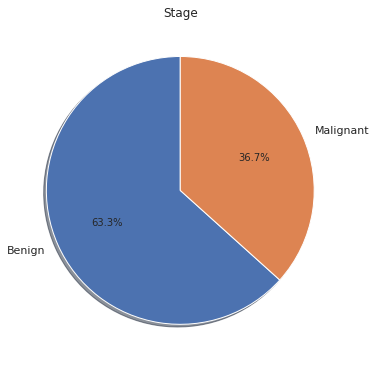

In [ ]:
Tumor_Type_flg = patient_info['Tumor_Type'].value_counts()
display(Tumor_Type_flg)
fig = plt.figure(figsize =(6, 9))
plt.pie( Tumor_Type_flg , labels=Tumor_Type_flg.index , autopct='%1.1f%%', shadow=True, startangle=90 )
plt.title('Stage')
plt.show()


In [ ]:
labels = {0:"Benign",1:"Malignant"}

In [ ]:
def get_data (data_dir ):
    X = list()
    y=list()
    img_size = 256
    for index, row in patient_info.iterrows():
        path = os.path.join(data_dir, str (row['Patient_Num']))
        label = row['Tumor_type_label']
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size                
                X.append(resized_arr)
                y.append(label)
            except Exception as e:
                print(e , row['Patient_Num'] )
    return X , y

X , y  = get_data("sample_data/Dalia_Data/")

In [ ]:
dict(zip(list(y),[list(y).count(i) for i in list(y)]))

{0.0: 2660, 1.0: 1540}

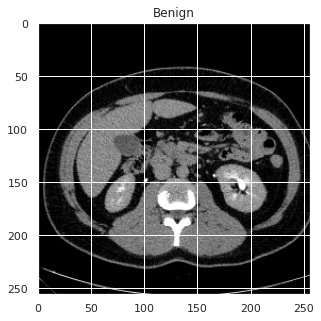

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(X[10])
plt.title(labels[y[10]])
plt.show()

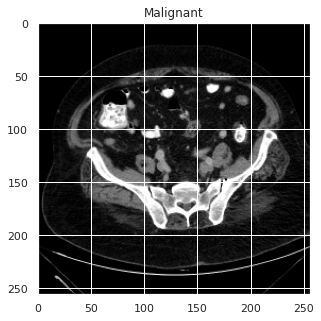

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(X[-20])
plt.title(labels[y[-20]])
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20)

In [ ]:
print ("Number images for training : {}".format(len (x_train)))
print ("Number images for testing : {}".format(len (x_test)))
print ("Number images for Validation : {}".format(len (x_val)))

Number images for training : 2688
Number images for testing : 840
Number images for Validation : 672


In [ ]:
dict(zip(list(y_val),[list(y_val).count(i) for i in list(y_val)]))

{0.0: 438, 1.0: 234}

In [ ]:
dict(zip(list(y_train),[list(y_train).count(i) for i in list(y_train)]))

{0.0: 1691, 1.0: 997}

In [ ]:
def data_prepare (X , y , folder_name , labels ) :
    path = "sample_data/{}".format(folder_name)
    os.mkdir(path)
    # create folder for labels 
    for key , value in labels.items()  : 
        path = "sample_data/{}/{}".format(folder_name,value)
        os.mkdir(path)

    if len (X) != len (y) : 
      print ("error size data X and y is not equal")
      return 

    for index , value in enumerate(y) : 
      im = Image.fromarray(X[index])
      path = "sample_data/{}/{}/{}.jpeg".format(folder_name,labels[value],str(index))
      im.save(path)
    return 



In [ ]:
data_prepare (X=x_train ,y=y_train ,folder_name="train", labels=labels )
data_prepare (X=x_test ,y=y_test ,folder_name="test", labels=labels )
data_prepare (X=x_val ,y=y_val ,folder_name="validation", labels=labels )


In [ ]:
## Genration Images 

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


validation_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/sample_data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

validation_set = validation_datagen.flow_from_directory('/content/sample_data/validation',
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'binary')


Found 2688 images belonging to 2 classes.
Found 672 images belonging to 2 classes.


In [ ]:
model= Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (224, 224, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 2, activation = 'softmax'))
model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 394272)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               50466944  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 50,468,098
Trainable params: 50,468,098
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist=model.fit(training_set,
                         steps_per_epoch = (2688 /128),
                         epochs = 50,
                         validation_data = validation_set,
                         validation_steps = (672 /128))

model.save("Tumer_type_classification.h5")
np.save('Tumer_type_classification_history_traning.npy',hist.history)
#history=np.load('/content/drive/MyDrive/Tumer_classification/Tumer_classification_dataset/32Iteration_model_history_tracing.npy',allow_pickle='TRUE').item()

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


21/21 [==============================] - 10s 383ms/step - loss: 2.5739 - accuracy: 0.5923 - val_loss: 0.7060 - val_accuracy: 0.6510
Epoch 2/50
21/21 [==============================] - 8s 386ms/step - loss: 0.7103 - accuracy: 0.6205 - val_loss: 0.5840 - val_accuracy: 0.6927
Epoch 3/50
21/21 [==============================] - 8s 391ms/step - loss: 0.6008 - accuracy: 0.6667 - val_loss: 0.5871 - val_accuracy: 0.6562
Epoch 4/50
21/21 [==============================] - 8s 394ms/step - loss: 0.5726 - accuracy: 0.6964 - val_loss: 0.5545 - val_accuracy: 0.6823
Epoch 5/50
21/21 [==============================] - 8s 387ms/step - loss: 0.5489 - accuracy: 0.7292 - val_loss: 0.3984 - val_accuracy: 0.7865
Epoch 6/50
21/21 [==============================] - 8s 382ms/step - loss: 0.5295 - accuracy: 0.7500 - val_loss: 0.4979 - val_accuracy: 0.7812
Epoch 7/50
21/21 [==============================] - 8s 391ms/step - loss: 0.4872 - accuracy: 0.7679 - val_loss: 0.3920 - val_accuracy: 0.7708
Epoch 8/50
21/21

In [ ]:
loss,accuracy=model.evaluate(validation_set)
print (f"Test Loss     = {loss}")
print (f"Test Accuracy = {accuracy}")

21/21 [==============================] - 1s 64ms/step - loss: 0.0643 - accuracy: 0.9777
Test Loss     = 0.06426610052585602
Test Accuracy = 0.9776785969734192


Number of images for Benign : 531


'=============================='

{'Benign': 474, 'Malignant': 57}

'=============================='

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


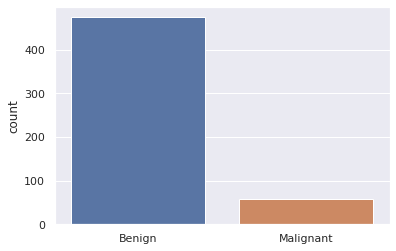

In [ ]:
from keras.preprocessing import image

path='/content/sample_data/test/Benign'
l_Benign =[]

filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Benign=[0]*len(filelist)
print ("Number of images for Benign :" , len (filelist))

for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Benign.append(test_image)

l_Benign_result=[]
for i in range(len(l_Benign)):
  xx = model.predict(l_Benign[i])
  xx = np.round(xx).astype(int)
  l_Benign_result.append(xx[0][1])

l_Benign_draw=[]
for i in range(len(l_Benign_result)):
    if(l_Benign_result[i] ==0):
        l_Benign_draw.append("Benign")
    else:
        l_Benign_draw.append("Malignant")

display('==='*10)
display(dict(zip(list(l_Benign_draw),[list(l_Benign_draw).count(i) for i in list(l_Benign_draw)])))
display('==='*10)

sns.set_style('darkgrid')
sns.countplot(l_Benign_draw)
plt.show()

Number of images for Malignant : 234


'=============================='

{'Benign': 5, 'Malignant': 229}

'=============================='

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


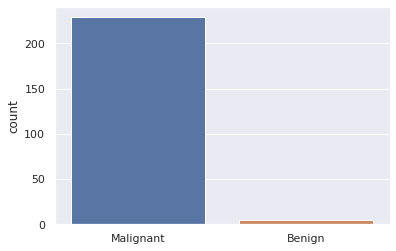

In [ ]:
path='/content/sample_data/validation/Malignant'
l_Malignant =[]

filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Malignant=[1]*len(filelist)
print ("Number of images for Malignant :" , len (filelist))

for img in filelist:
  test_image = image.load_img(os.path.join(path, img), target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Malignant.append(test_image)

l_Malignant_result=[]
for i in range(len(l_Malignant)):
  xx= model.predict(l_Malignant[i])
  xx = np.round(xx).astype(int)
  l_Malignant_result.append(xx[0][1])

l_Malignant_draw=[]
for i in range(len(l_Malignant_result)):

    if (l_Malignant_result[i] ==1):
        l_Malignant_draw.append("Malignant")
    else:
        l_Malignant_draw.append("Benign")

display('==='*10)
display(dict(zip(list(l_Malignant_draw),[list(l_Malignant_draw).count(i) for i in list(l_Malignant_draw)])))
display('==='*10)

sns.set_style('darkgrid')
sns.countplot(l_Malignant_draw)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

print('Training Set Clases')
print(training_set.class_indices)
print('Testing Set Clases')
print(validation_set.class_indices)

print('\nConfusion Matrix')
print('Classification Report')
target_names = ['Benign', 'Malignant']
print(classification_report(y_Malignant+y_Benign , l_Malignant_result+l_Benign_result, target_names=target_names))

Training Set Clases
{'Benign': 0, 'Malignant': 1}
Testing Set Clases
{'Benign': 0, 'Malignant': 1}

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

      Benign       0.99      0.89      0.94       531
   Malignant       0.80      0.98      0.88       234

    accuracy                           0.92       765
   macro avg       0.90      0.94      0.91       765
weighted avg       0.93      0.92      0.92       765



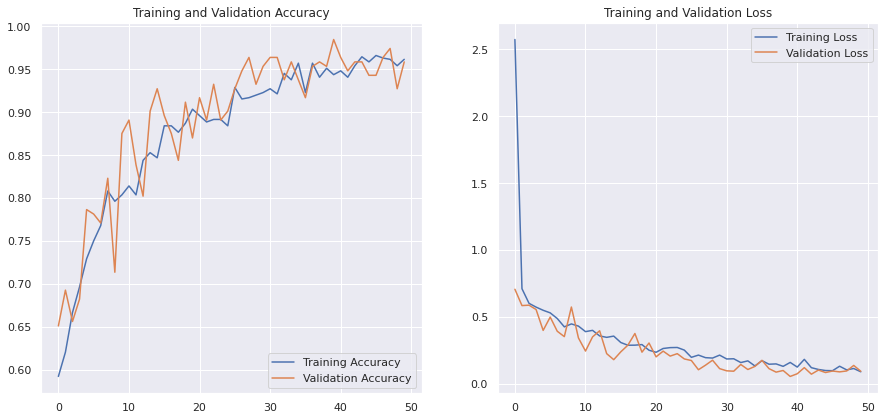

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save("Tumer_type_classification.h5")
np.save('Tumer_type_classification_history_traning.npy',hist.history)